# ISSIA Processing with Progress Tracking

This notebook shows how to process ATCOR-4 files with detailed progress information.

In [ ]:
# Install required packages if needed
# !pip install tqdm dask[array] rasterio numpy scipy matplotlib xarray

In [1]:
import numpy as np
from pathlib import Path
from issia_notebook import ISSIAProcessorNotebook, process_with_monitoring
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


## Step 1: Initialize Processor

Set `verbose=True` to see detailed progress at each step.

In [2]:
# Define instrument parameters
wavelengths = np.linspace(380, 2500, 451)  # AisaFENIX example

# LUT dimensions (must match your generated LUTs)
grain_radii = np.logspace(np.log10(30), np.log10(5000), 50)
illumination_angles = np.arange(0, 85, 5)
viewing_angles = np.arange(0, 65, 5)
relative_azimuths = np.arange(0, 185, 15)

# Initialize processor with verbose mode
processor = ISSIAProcessorNotebook(
    wavelengths=wavelengths,
    grain_radii=grain_radii,
    illumination_angles=illumination_angles,
    viewing_angles=viewing_angles,
    relative_azimuths=relative_azimuths,
    coord_ref_sys_code=32610,  # Adjust for your area
    chunk_size=(512, 512),      # Adjust based on available RAM
    verbose=True                # Enable progress messages
)

print("\n✓ Processor initialized")
print(f"  Wavelengths: {len(wavelengths)}")
print(f"  Grain sizes: {len(grain_radii)}")
print(f"  Chunk size: {processor.chunk_size}")


✓ Processor initialized
  Wavelengths: 451
  Grain sizes: 50
  Chunk size: (512, 512)


## Step 2: Load Lookup Tables

This will show progress as each LUT is loaded.

In [3]:
lut_dir = Path("lookup_tables")

processor.load_lookup_tables(
    sbd_lut_path=lut_dir / "sbd_lut.npy",
    anisotropy_lut_path=lut_dir / "anisotropy_lut.npy",
    albedo_lut_path=lut_dir / "albedo_lut.npy"
)

print("\n✓ All lookup tables loaded successfully")

Loading lookup tables...
Lookup tables loaded successfully

✓ All lookup tables loaded successfully


## Step 3: Process Flight Line

Now process with detailed progress at each step:

In [ ]:
# Set paths
#data_dir = Path("atcor_output")
#data_dir=Path("testing/")
#data_dir=Path("/Volumes/aco-uvic/2021_Acquisitions/02_Processed/21_4012_06_Place_CryoMB/03_Hyper/02_Working/OUTPUT/subsets/")
data_dir = Path('/Volumes/aco-uvic/2022_Acquisitions/02_Processed/22_4012_07_PlaceGlacier/03_Hyper/02_Working/OUTPUT/subsets/')
flight_line = '22_4012_07_2022-08-07_19-54-01-rect_img'

output_dir = Path("issia_results")
#flight_line = "21_4012_06_2021-07-12_18-50-43-rect_img"

# # Process with monitoring
# output_files = process_with_monitoring(
#     processor=processor,
#     data_dir=data_dir,
#     flight_line=flight_line,
#     output_dir=output_dir,
#     viewing_angle=0.0,
#     solar_azimuth=180.0
# )

# Test on just 500x500 pixels (top-left corner)
output_files = processor.process_flight_line(
    data_dir=data_dir,
    flight_line=flight_line,
    output_dir=output_dir,
    #viewing_angle=0.0,
    #solar_azimuth=180.0,
    subset=(1000, 1500, 1000, 1500)
)



PROCESSING FLIGHT LINE: 22_4012_07_2022-08-07_19-54-01-rect_img
SUBSET MODE: rows 1000-1500, cols 1000-1500

[20:12:34] INFO: Reading ATCOR files for flight line: 22_4012_07_2022-08-07_19-54-01-rect_img
[20:12:34] INFO: Checking for required files...
[20:12:34] INFO:   ✓ Found 22_4012_07_2022-08-07_19-54-01-rect_img.inn (0.0 MB)
[20:12:34] INFO:   ✓ Found 22_4012_07_2022-08-07_19-54-01-rect_img_atm.dat (4454.3 MB)
[20:12:34] INFO:   ✓ Found 22_4012_07_2022-08-07_19-54-01-rect_img_eglo.dat (4454.3 MB)
[20:12:34] INFO:   ✓ Found 22_4012_07_2022-08-07_19-54-01-rect_img_slp.dat (19.7 MB)
[20:12:34] INFO:   ✓ Found 22_4012_07_2022-08-07_19-54-01-rect_img_asp.dat (19.7 MB)
Reading subset window: rows 1000-1500, cols 1000-1500


Loading 5 files...
  [1/5] Loading Reflectance...

## Step 4: Visualize Results

Quick visualization of the outputs:

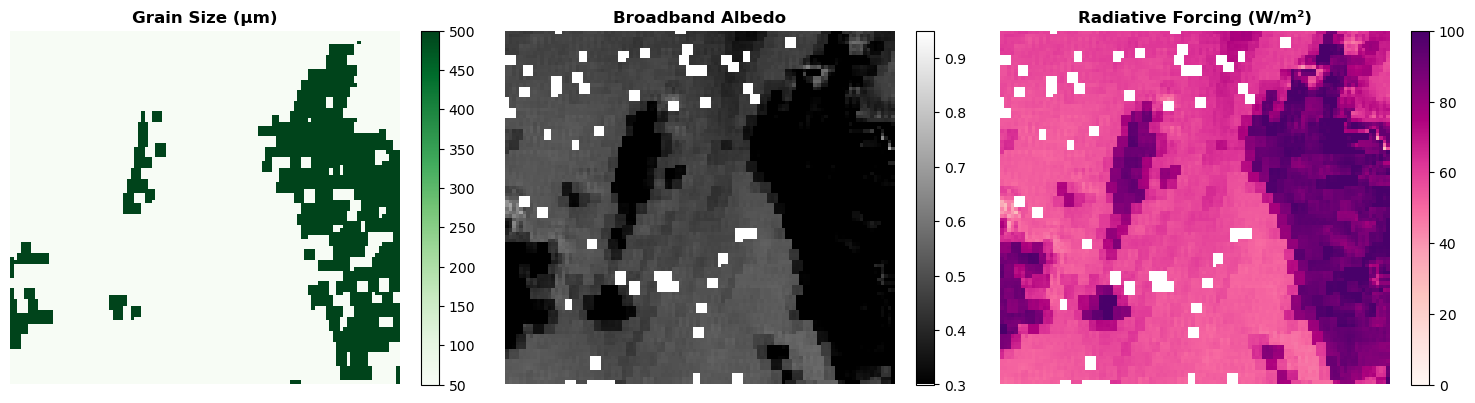


✓ Visualization complete


In [8]:
import matplotlib.pyplot as plt
import rasterio

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Load and plot grain size
with rasterio.open(output_files['grain_size']) as src:
    grain_size = src.read(1)

im1 = axes[0].imshow(grain_size, cmap='Greens', vmin=50, vmax=500)
axes[0].set_title('Grain Size (μm)', fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Load and plot broadband albedo
with rasterio.open(output_files['broadband_albedo']) as src:
    albedo = src.read(1)

im2 = axes[1].imshow(albedo, cmap='gray', vmin=0.3, vmax=0.95)
axes[1].set_title('Broadband Albedo', fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# Load and plot radiative forcing
with rasterio.open(output_files['radiative_forcing']) as src:
    rf = src.read(1)

im3 = axes[2].imshow(rf, cmap='RdPu', vmin=0, vmax=100)
axes[2].set_title('Radiative Forcing (W/m²)', fontweight='bold')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

In [6]:
inn_file = Path('/Volumes/aco-uvic/2022_Acquisitions/02_Processed/22_4012_07_PlaceGlacier/03_Hyper/02_Working/OUTPUT/subsets/22_4012_07_2022-08-07_19-54-01-rect_img.inn')

with open(inn_file, 'r') as f:
    print(f.read())

07-08-2022         Date (dd-mm-year)
100.0              Scale factor reflectance
1.00             Pixel size [m]          
FENIX_2021, FENIX_2021,
1.00000        gainset,  c1 = c1(calfile) / gainset
U:\2022_Acquisitions\02_Processed\22_4012_07_PlaceGlacier\03_Hyper\02_Working\OUTPUT\22_4012_07_2022-08-07_19-54-01-rect_rad.cal
U:\2022_Acquisitions\02_Processed\22_4012_07_PlaceGlacier\03_Hyper\02_Working\OUTPUT\22_4012_07_2022-08-07_19-54-01-rect_sca.bsq
0.9900  0           iemiss, dem_unit  (0=[m], 1=[dm], 2=[cm])
22_4012_07_2022-08-07_19-54-01-rect_img_ele.bsq
22_4012_07_2022-08-07_19-54-01-rect_img_slp.bsq
22_4012_07_2022-08-07_19-54-01-rect_img_asp.bsq
22_4012_07_2022-08-07_19-54-01-rect_img_sky.bsq

h04000_wv04_rura.atm

0.600              Adjacency range [km]
50.0              Visibility [km]
2.100              Mean ground elevation [km]
38.1   177.2       Solar zenith, azimuth [degree]
4.000 176.458     Flight altit [km], heading[deg]
0   1   0   0   0   1   0     npref, iwaterwv,